In [1]:
!pip install pandas numpy networkx scikit-learn matplotlib pyngrok > /dev/null
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('resume_data.csv')  # Replace with your filename

In [2]:
# Create career sequences for each candidate
career_sequences = df.groupby('address').apply(
    lambda x: x.sort_values('start_dates')['positions'].tolist()
).reset_index(name='career_path')

# Filter meaningful transitions (minimum 2 positions)
career_sequences = career_sequences[career_sequences['career_path'].apply(len) > 1]

# Build transition matrix
all_positions = list(set([pos for path in career_sequences['career_path'] for pos in path]))
transition_matrix = pd.DataFrame(0, index=all_positions, columns=all_positions)

for path in career_sequences['career_path']:
    for i in range(len(path)-1):
        transition_matrix.loc[path[i], path[i+1]] += 1

# Normalize probabilities
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)

<ipython-input-2-35962b9ebe9d>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  career_sequences = df.groupby('address').apply(



Likely Career Paths from Software Developer (Machine Learning Engineer):
Similar to Software Developer (Machine Learning Engineer): ["['Software Developer (Machine Learning Engineer)']"]


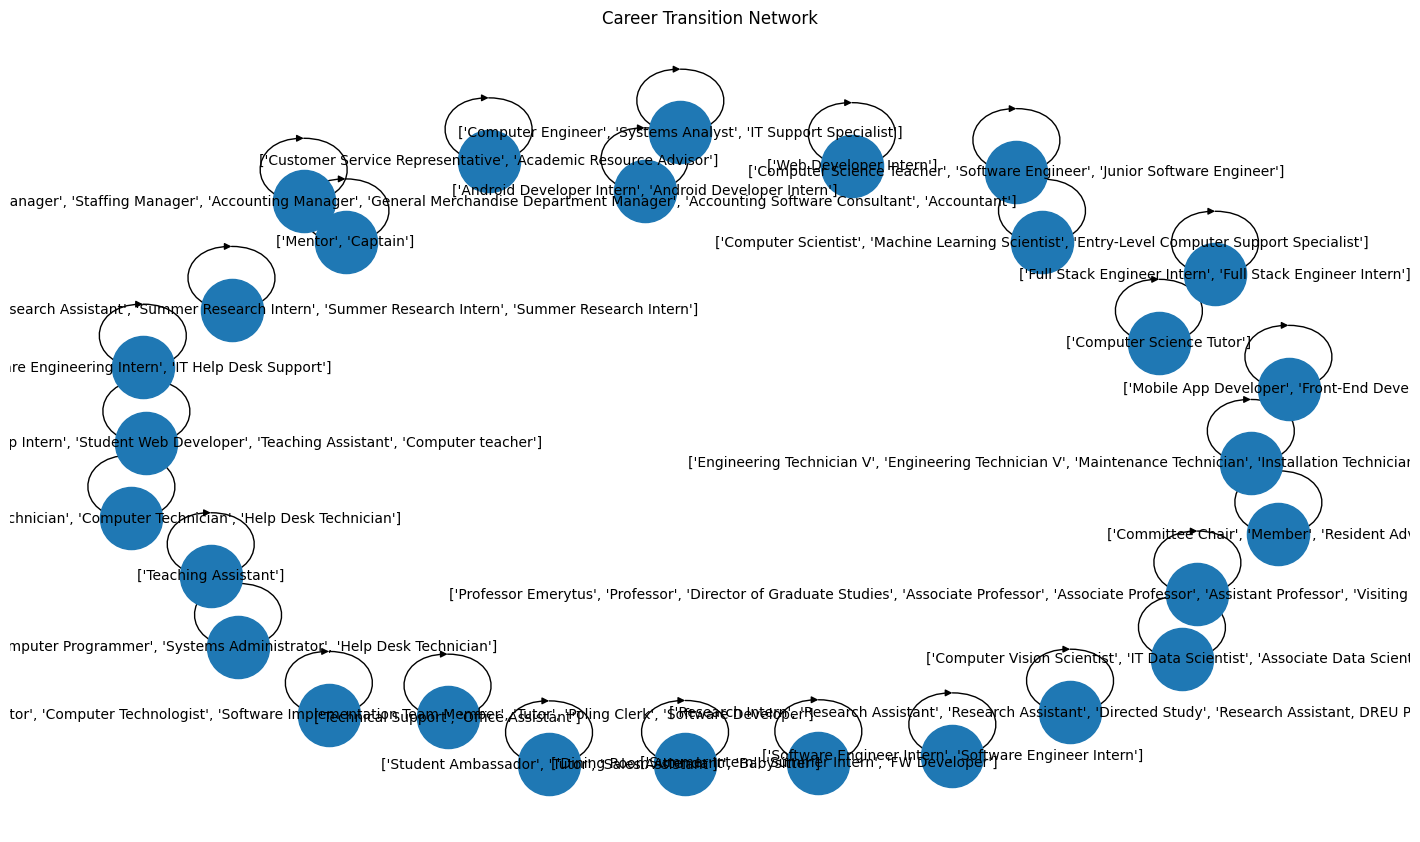

In [7]:
import re

class CareerPredictor:
    def __init__(self, transition_matrix):
        self.transition_matrix = transition_matrix
        self.G = nx.from_pandas_adjacency(transition_matrix, create_using=nx.DiGraph)

    def predict_next_steps(self, current_position, top_n=5):
        try:
            return dict(sorted(
                self.transition_matrix.loc[current_position].items(),
                key=lambda x: x[1],
                reverse=True
            )[:top_n])
        except KeyError:
            return self.handle_unknown_position(current_position)

    def handle_unknown_position(self, position):
        # Ensure we drop NaN and align indices before filtering
        df_cleaned = df.dropna(subset=['positions']).reset_index(drop=True)
        # Escape special characters to avoid regex warning
        position_pattern = re.escape(position)
        similar_roles = df_cleaned[df_cleaned['positions'].str.contains(position_pattern, case=False, na='', regex=True)]['positions'].unique()
        if len(similar_roles) > 0:
            return {f"Similar to {position}": list(similar_roles)[:5]}
        else:
            return {f"Similar to {position}": "No similar roles found"}

    def visualize_path(self, current_position):
        plt.figure(figsize=(14,8))
        pos = nx.spring_layout(self.G)
        nx.draw(self.G, pos, with_labels=True, node_size=2000, font_size=10)
        plt.title("Career Transition Network")
        plt.show()

# Initialize predictor
predictor = CareerPredictor(transition_matrix)

current_role = "Software Developer (Machine Learning Engineer)"
predictions = predictor.predict_next_steps(current_role)

print(f"\nLikely Career Paths from {current_role}:")
for role, prob in predictions.items():
    # Ensure prob is a numeric value before formatting
    if isinstance(prob, (int, float)):
        print(f"{role}: {prob:.1%} probability")
    else:
        print(f"{role}: {prob}")  # In case it's a string like 'No similar roles found'

# Visualize full career network
predictor.visualize_path(current_role)


In [11]:
def enhanced_prediction(current_role, user_skills):
    base_predictions = predictor.predict_next_steps(current_role)

    # Get skill requirements for predicted roles
    skill_requirements = {
        role: set(df[df['positions'] == role]['skills'].explode().value_counts().index[:5])
        for role in base_predictions
    }

    # Calculate skill match percentage
    user_skill_set = set(user_skills.split(', '))
    enhanced_predictions = {}

    for role, prob in base_predictions.items():
        required_skills = skill_requirements.get(role, set())
        match_pct = len(user_skill_set & required_skills)/len(required_skills) if required_skills else 0

        # Ensure prob is numeric before formatting
        if isinstance(prob, (int, float)):
            prob_str = f"{prob:.1%}"
        else:
            prob_str = "N/A"  # If prob is not numeric, return N/A or handle as needed

        enhanced_predictions[role] = {
            'base_probability': prob_str,
            'skill_match': f"{match_pct:.1%}",
            'missing_skills': list(required_skills - user_skill_set)[:3]
        }

    return enhanced_predictions

# Test enhanced prediction
user_skills = "Python, Machine Learning, TensorFlow"
enhanced = enhanced_prediction(current_role, user_skills)

print("\nEnhanced Predictions with Skill Matching:")
for role, details in enhanced.items():
    print(f"\n{role}")
    print(f"- Base Probability: {details['base_probability']}")
    print(f"- Skill Match: {details['skill_match']}")
    print(f"- Critical Missing Skills: {details['missing_skills']}")



Enhanced Predictions with Skill Matching:

Similar to Software Developer (Machine Learning Engineer)
- Base Probability: N/A
- Skill Match: 0.0%
- Critical Missing Skills: []


In [12]:
import pickle

# Save the transition_matrix and predictor model to a file
with open('career_predictor_model.pkl', 'wb') as file:
    pickle.dump(predictor, file)  # Save the whole predictor object, including the transition matrix

# Optionally, save just the transition matrix if you'd like to reload only the data
with open('transition_matrix.pkl', 'wb') as file:
    pickle.dump(transition_matrix, file)


{'Similar to ios devoloper': 'No similar roles found'}


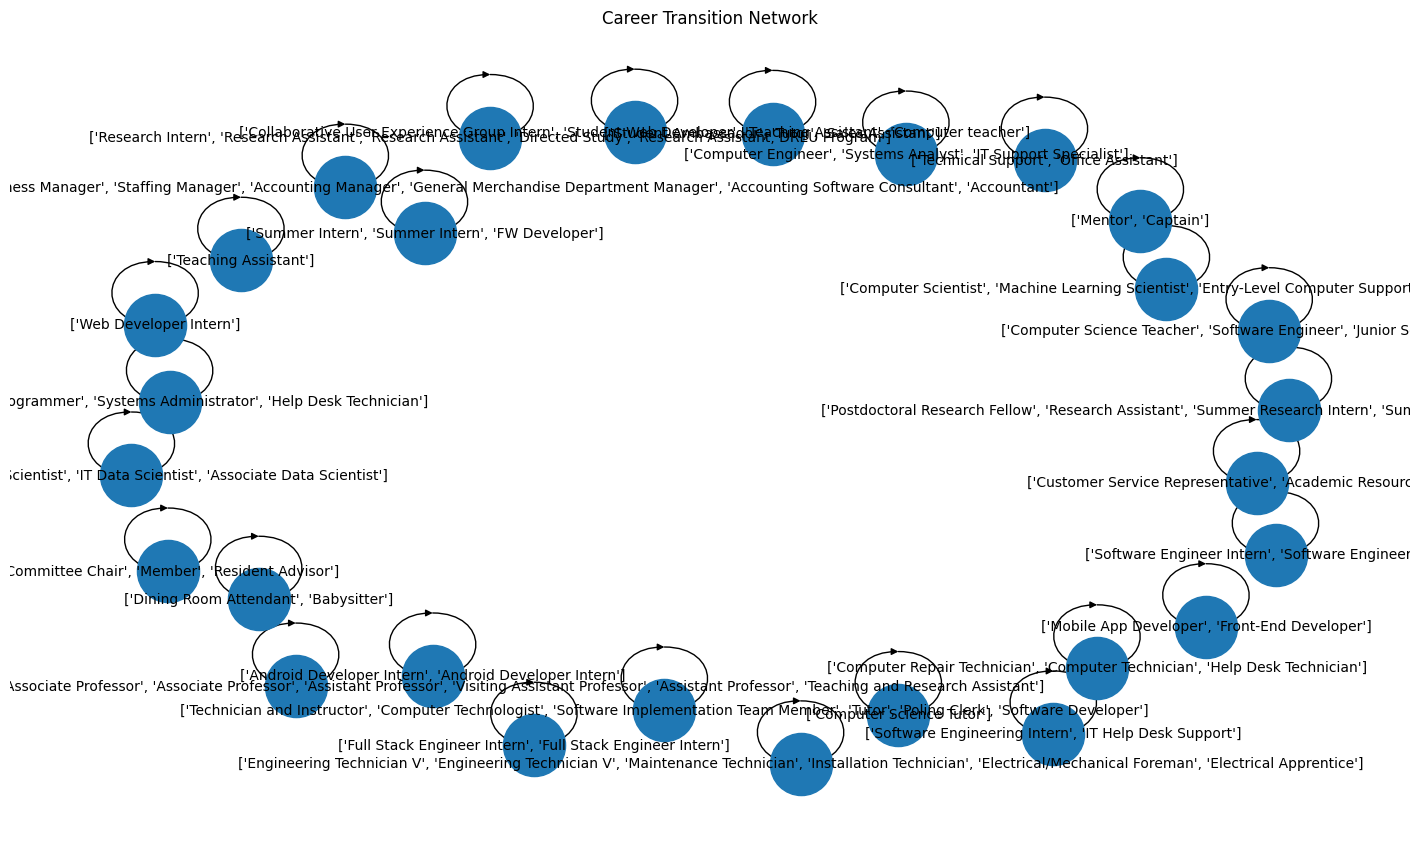

In [15]:
# Load the saved model
with open('career_predictor_model.pkl', 'rb') as file:
    loaded_predictor = pickle.load(file)  # Load the entire predictor object, including the transition matrix

# Optionally, if you only saved the transition_matrix, load it like this
with open('transition_matrix.pkl', 'rb') as file:
    loaded_transition_matrix = pickle.load(file)

# Now you can use the loaded predictor or transition_matrix
current_role = "ios devoloper"
predictions = loaded_predictor.predict_next_steps(current_role)
print(predictions)
predictor.visualize_path(current_role)
